In [7]:
import os

import albumentations as A
from albumentations.pytorch import ToTensorV2
from copy import deepcopy
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd

from sklearn.metrics import f1_score

import torch
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.nn.functional import binary_cross_entropy_with_logits, cross_entropy
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau

from tqdm.notebook import tqdm

from classification_model import ClassificationModel
from custom_image_dataset import CustomImageDataset
from src.dataset.constants import ANATOMICAL_REGIONS

%matplotlib inline

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"We use: {device}")

We use: cuda


# I. Datasets and Dataloaders

#### Load dataset csv files as pd dataframes and print statistics

In [8]:
path_chest_imagenome_customized = "/u/home/tanida/datasets/chest-imagenome-dataset-customized-full"

# reduce memory usage by only using necessary columns and selecting appropriate datatypes
usecols = ["mimic_image_file_path", "bbox_name", "x1", "y1", "x2", "y2", "is_abnormal"]
dtype = {"x1": "int16", "x2": "int16", "y1": "int16", "y2": "int16", "bbox_name": "category"} 

datasets_as_dfs = {dataset: os.path.join(path_chest_imagenome_customized, dataset) + ".csv" for dataset in ["train", "valid", "test"]}
datasets_as_dfs = {dataset: pd.read_csv(csv_file_path, usecols=usecols, dtype=dtype) for dataset, csv_file_path in datasets_as_dfs.items()}

In [4]:
def print_num_samples_per_class(dataset, df):
    print(f"{dataset}:")
    for bbox_name, count in df["bbox_name"].value_counts().iteritems():
        print(f"\t{bbox_name}: {count}")
    print()

In [ ]:
# get number of samples per class for each dataset

# bboxes of anatomical regions are almost distributed equally in all datasets,
# only a slight imbalance because not every image has bboxes of all 36 anatomical regions
for dataset, df in datasets_as_dfs.items():
    print_num_samples_per_class(dataset, df)

In [8]:
# get number of samples for each dataset
total_num_samples = sum(len(df) for df in datasets_as_dfs.values())

for dataset, df in datasets_as_dfs.items():
    print(f"{dataset}: {len(df):,} images ({(len(df) / total_num_samples) * 100:.2f}%)")

train: 5,496,722 images (69.99%)
valid: 793,442 images (10.10%)
test: 1,563,839 images (19.91%)


In [5]:
# if we don't want to train on the full train set (with over 5,000,000 samples), we can specify the constant below to limit the train set

PERCENTAGE_OF_TRAIN_SET_TO_USE = 0.1
total_num_samples_train = len(datasets_as_dfs["train"])

new_num_samples_train = int(PERCENTAGE_OF_TRAIN_SET_TO_USE * total_num_samples_train)

datasets_as_dfs["train"] = datasets_as_dfs["train"][:new_num_samples_train]

print(f"train (new): {len(datasets_as_dfs['train']):,} samples")

train (new): 5,496 samples


In [6]:
# if we don't want to validate on the full val set, we can specify the constant below to limit the val set

PERCENTAGE_OF_VAL_SET_TO_USE = 0.5
total_num_samples_val = len(datasets_as_dfs["valid"])

new_num_samples_val = int(PERCENTAGE_OF_VAL_SET_TO_USE * total_num_samples_val)

datasets_as_dfs["valid"] = datasets_as_dfs["valid"][:new_num_samples_val]

print(f"valid (new): {len(datasets_as_dfs['valid']):,} samples")

valid (new): 7,934 samples


#### Load datasets and dataloaders

In [4]:
# constants for image transformations

# see compute_mean_std_dataset.py in src/dataset
mean = 0.471
std = 0.302

# pre-trained DenseNet121 model expects images to be of size 224x224
IMAGE_INPUT_SIZE = 224

In [5]:
# note: transforms are applied to the already cropped images (see __getitem__ method of CustomImageDataset class)!

# use albumentations for Compose and transforms
train_transforms = A.Compose([
    # we want the long edge of the image to be resized to IMAGE_INPUT_SIZE, and the short edge of the image to be padded to IMAGE_INPUT_SIZE on both sides,
    # such that the aspect ratio of the images are kept (i.e. a resized image of a lung is not distorted), 
    # while getting images of uniform size (IMAGE_INPUT_SIZE x IMAGE_INPUT_SIZE)
    A.LongestMaxSize(max_size=IMAGE_INPUT_SIZE, interpolation=cv2.INTER_AREA),  # resizes the longer edge to IMAGE_INPUT_SIZE while maintaining the aspect ratio (INTER_AREA works best for shrinking images)
    A.PadIfNeeded(min_height=IMAGE_INPUT_SIZE, min_width=IMAGE_INPUT_SIZE, border_mode=cv2.BORDER_CONSTANT),  # pads both sides of the shorter edge with 0's (black pixels)
    # A.HueSaturationValue(),
    # A.Affine(mode=cv2.BORDER_CONSTANT),
    # A.GaussianBlur(),
    A.Normalize(mean=mean, std=std),
    ToTensorV2()
])

# don't apply data augmentations to val and test set
val_test_transforms = A.Compose([
    A.LongestMaxSize(max_size=IMAGE_INPUT_SIZE, interpolation=cv2.INTER_AREA),
    A.PadIfNeeded(min_height=IMAGE_INPUT_SIZE, min_width=IMAGE_INPUT_SIZE, border_mode=cv2.BORDER_CONSTANT),
    A.Normalize(mean=mean, std=std),
    ToTensorV2()
])

In [6]:
train_dataset = CustomImageDataset(dataset_df=datasets_as_dfs["train"], transforms=train_transforms)
val_dataset = CustomImageDataset(dataset_df=datasets_as_dfs["valid"], transforms=val_test_transforms)
test_dataset = CustomImageDataset(dataset_df=datasets_as_dfs["test"], transforms=val_test_transforms)

In [17]:
# compute what value to set for num_workers in dataloaders
BATCH_SIZE = 64

from time import time
import multiprocessing as mp

def compute_optimal_num_workers():
    for num_workers in range(2, mp.cpu_count(), 4):
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers, pin_memory=True)
        start = time()
        num_batches = 100
        for i, batch in enumerate(tqdm(train_loader, total=num_batches)):
            if i >= num_batches:
                break
        end = time()
        print(f"Finish with: {end - start:.2f} second, num_workers={num_workers}")

compute_optimal_num_workers()

  0%|          | 0/100 [00:00<?, ?it/s]

Finish with:38.59 second, num_workers=48


In [ ]:
def collate_fn(batch):
    # discard images from batch where __getitem__ from custom_image_dataset failed
    # otherwise, whole training loop will stop (even if only 1 image fails to open)
    batch = list(filter(lambda x: x is not None, batch))
    return torch.utils.data.dataloader.default_collate(batch)

In [12]:
BATCH_SIZE = 64
NUM_WORKERS = 48

train_loader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_dataset, collate_fn=collate_fn, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

#### Visualize some images

In [16]:
# get the first batch of the validation set
batch = next(iter(val_loader))

# batch is a dict with keys for 'image', 'bbox_target', 'is_abnormal_target' (see custom_image_dataset)
batch_images, bbox_targets, is_abnormal_targets = batch.values()

# get the path to the first image (image of whole chest) in the validation set
chest_image_file_path = datasets_as_dfs["valid"].iloc[0, 0]
chest_image = cv2.imread(chest_image_file_path, cv2.IMREAD_UNCHANGED)  # read the image in with 1 channel (grayscale)

In [17]:
def show_chest_image_and_bbox_image_side_by_side(bbox_image_tensor, bbox_name, bbox_coordinates):
    """Imshow the first chest image of the validation set with a red bbox on the left, 
    and the transformed (i.e. resized and padded) bbox image of that region on the right.

    Since the val loader is not shuffled, we know that the first 36 bbox images in the val loader belong to the first chest image in the val dataset.

    Args:
        bbox_image_tensor (torch.Tensor): single image tensor of bbox inside first batch of val loader
        bbox_name (str): name of the bbox
        bbox_coordinates (tuple): 4 integers specifying the location of the bbox on the chest image
    """
    # transform torch.Tensor to np.ndarray and transpose dimensions such that channel dimension is last (numpy convention)
    bbox_image_np = bbox_image_tensor.numpy()
    bbox_image_np = np.transpose(bbox_image_np, (1, 2, 0))

    _, axs = plt.subplots(1, 2, figsize=(12, 12))

    # show the whole chest image on the left side
    axs[0].imshow(chest_image, cmap='gray')

    # add red bbox on chest iamge
    x1, y1, x2, y2 = bbox_coordinates
    height = y2 - y1
    width =  x2 - x1
    bbox = patches.Rectangle((x1, y1), width, height, linewidth=1, edgecolor='r', facecolor='none')
    axs[0].add_patch(bbox)

    # show the bbox image on the right side
    axs[1].imshow(bbox_image_np, cmap='gray')

    # set the bbox name as title
    axs[1].set_title(bbox_name)

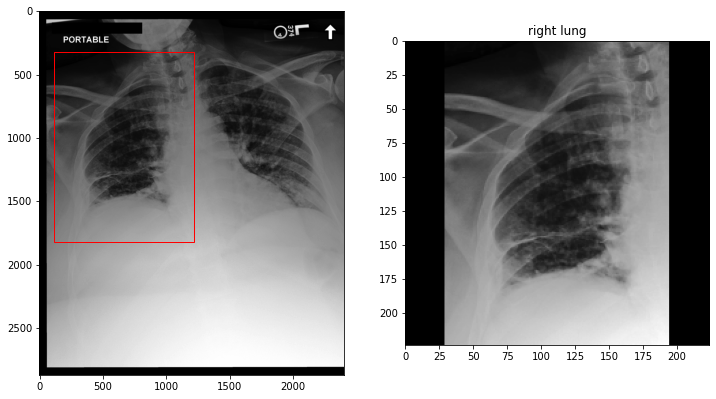

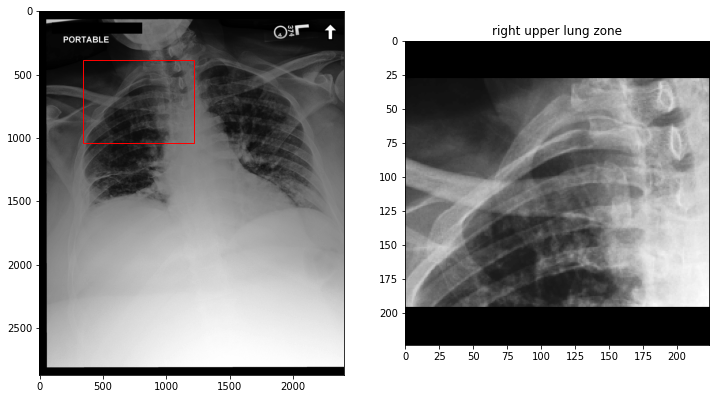

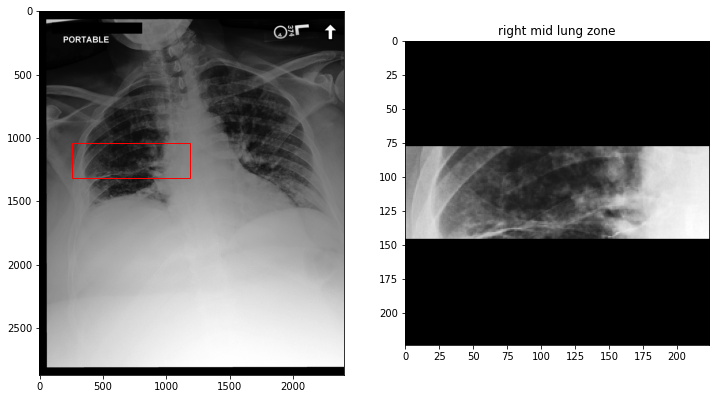

In [18]:
NUM_ANATOMICAL_REGIONS = 36

for i in range(NUM_ANATOMICAL_REGIONS):
    bbox_image_tensor = batch_images[i]
    bbox_name = datasets_as_dfs["valid"].iloc[i, 1]  # 2nd column is bbox_name
    bbox_coordinates = datasets_as_dfs["valid"].iloc[i, 2:6]  # 3rd column to 6th column are bbox_coordinates

    show_chest_image_and_bbox_image_side_by_side(bbox_image_tensor, bbox_name, bbox_coordinates)

# II. Training the Model

#### Testing the functionality of f1-score function

In [18]:
batch = next(iter(val_loader))

# batch is a dict with keys for 'image', 'bbox_target', 'is_abnormal_target' (see custom_image_dataset)
batch_images, bbox_targets, is_abnormal_targets = batch.values()

print(batch_images.is_cuda)

model = ClassificationModel()
model.to(device, non_blocking=True)

batch_images = batch_images.to(device, non_blocking=True)
bbox_targets = bbox_targets.to(device, non_blocking=True)
is_abnormal_targets = is_abnormal_targets.to(device, non_blocking=True)

False


In [19]:
logits = model(batch_images)
# use the first 36 columns as logits for bbox classes, shape: (BATCH_SIZE, 36)
bbox_class_logits = logits[:, :36]

# use the last column (i.e. 37th column) as logits for the is_abnormal binary class, shape: (BATCH_SIZE)
abnormal_logits = logits[:, -1]

preds_bbox = torch.argmax(bbox_class_logits, dim=1)
preds_is_abnormal = abnormal_logits > 0

print(preds_bbox.shape)
print(preds_is_abnormal.shape)

torch.Size([64])
torch.Size([64])


In [28]:
print(bbox_targets[:5].cpu())
print(preds_bbox[:5].cpu())

tensor([0, 1, 2, 3, 4], dtype=torch.uint8)
tensor([15, 15, 15, 15, 15])


In [38]:
gt = torch.tensor([0, 1, 2, 1])
pred = torch.tensor([0, 2, 1, 1])

In [43]:
f1_score(gt, pred, average=None, labels=[i for i in range(5)])

array([1. , 0.5, 0. , 0. , 0. ])

In [24]:
print(preds_is_abnormal[:5].cpu())
print(is_abnormal_targets[:5].cpu())

f1_score(is_abnormal_targets[:5].cpu(), preds_is_abnormal[:5].cpu())

tensor([False, False, False, False, False])
tensor([1., 0., 0., 0., 1.])


0.0

In [26]:
gt = torch.tensor([1, 0, 0, 0, 1])
pred = torch.tensor([0, 0, 0, 0, 1])
f1_score(gt, pred)

0.6666666666666666

#### Specify where to save trained model weights

In [6]:
model_save_path = "/u/home/tanida/weights/classification_model"

#### Specify training function

In [ ]:
def train_one_epoch(model, train_dl, optimizer, epoch):
    """
    Train model for 1 epoch.
    Write train loss to tensorboard.

    Args:
        model (nn.Module): The input model to be trained.
        train_dl (torch.utils.data.Dataloder): The train dataloader to train on.
        optimizer (Optimizer): The model's optimizer.
        epoch (int): Current epoch number.

    Returns:
        train_loss (float): Train loss for 1 epoch.
    """
    # training the model on the train set
    model.train()
    train_loss = 0.0
    
    for batch in tqdm(train_dl):
        # batch is a dict with keys for 'image', 'bbox_target', 'is_abnormal_target' (see custom_image_dataset)
        batch_images, bbox_targets, is_abnormal_targets = batch.values()

        batch_size = batch_images.size(0)

        batch_images = batch_images.to(device, non_blocking=True) # shape: (BATCH_SIZE, 1, IMAGE_INPUT_SIZE, IMAGE_INPUT_SIZE), with IMAGE_INPUT_SIZE usually 224
        bbox_targets = bbox_targets.to(device, non_blocking=True) # shape: (BATCH_SIZE), integers between 0 and 35 specifying the class for each bbox image
        is_abnormal_targets = is_abnormal_targets.to(device, non_blocking=True) # shape: (BATCH_SIZE), floats that are either 0. (normal) or 1. (abnormal) specifying if bbox image is normal/abnormal

        # logits has output shape: (BATCH_SIZE, 37)
        logits = model(batch_images)

        # use the first 36 columns as logits for bbox classes, shape: (BATCH_SIZE, 36)
        bbox_class_logits = logits[:, :36]

        # use the last column (i.e. 37th column) as logits for the is_abnormal binary class, shape: (BATCH_SIZE)
        abnormal_logits = logits[:, -1]

        # compute the (multi-class) cross entropy loss
        cross_entropy_loss = cross_entropy(bbox_class_logits, bbox_targets)

        # compute the binary cross entropy loss
        binary_cross_entropy_loss = binary_cross_entropy_with_logits(abnormal_logits, is_abnormal_targets)

        # total loss is weighted 1:1 between cross_entropy_loss and binary_cross_entropy_loss
        total_loss = cross_entropy_loss + binary_cross_entropy_loss
        
        total_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        train_loss += total_loss.item() * batch_size
        
    train_loss /= len(train_dl)
    
    writer.add_scalar('training loss', train_loss, epoch)

    return train_loss

In [ ]:
def evaluate_one_epoch(model, val_dl, lr_scheduler, epoch):
    """
    Evaluate model on val set.
    
    Write to tensorboard:
        - val loss
        - val f1_score is_abnormal
        - val f1_score bboxes
        - val f1_score bbox for 36 bbox regions

    Args:
        model (nn.Module): The input model to be evaluated.
        val_dl (torch.utils.data.Dataloder): The val dataloader to evaluate on.
        lr_scheduler (torch.optim.lr_scheduler): The learning rate scheduler to use.
        epoch (int): Current epoch number.

    Returns:
        val_loss (float): Val loss for 1 epoch.
        f1_scores_is_abnormal (float): Average f1 score for is_abnormal variable for 1 epoch.
        f1_scores_bboxes (float): Average global f1 score for bboxes for 1 epoch.
        f1_scores_bboxes_class (list[float]): Average f1 score for each bbox class for 1 epoch.

    """
    # evaluating the model on the val set
    model.eval()
    val_loss = 0.0
    
    num_classes = len(ANATOMICAL_REGIONS)

    # list collects the f1-scores of is_abnormal variables calculated for each epoch
    f1_scores_is_abnormal = []

    # list collects the global f1-scores of bboxes calculated for each epoch
    f1_scores_bboxes = []

    # list of list where inner list collects the f1-scores calculated for each bbox class for each epoch
    f1_scores_bboxes_class = [[] for _ in range(num_classes)]
    
    for batch in tqdm(val_dl):
        batch_images, bbox_targets, is_abnormal_targets = batch.values()

        batch_size = batch_images.size(0)

        batch_images = batch_images.to(device, non_blocking=True) # shape: (BATCH_SIZE, 1, IMAGE_INPUT_SIZE, IMAGE_INPUT_SIZE), with IMAGE_INPUT_SIZE usually 224
        bbox_targets = bbox_targets.to(device, non_blocking=True) # shape: (BATCH_SIZE), integers between 0 and 35 specifying the class for each bbox image
        is_abnormal_targets = is_abnormal_targets.to(device, non_blocking=True) # shape: (BATCH_SIZE), floats that are either 0. (normal) or 1. (abnormal) specifying if bbox image is normal/abnormal

        # logits has output shape: (BATCH_SIZE, 37)
        logits = model(batch_images)

        # use the first 36 columns as logits for bbox classes, shape: (BATCH_SIZE, 36)
        bbox_class_logits = logits[:, :36]

        # use the last column (i.e. 37th column) as logits for the is_abnormal binary class, shape: (BATCH_SIZE)
        abnormal_logits = logits[:, -1]

        cross_entropy_loss = cross_entropy(bbox_class_logits, bbox_targets)
        binary_cross_entropy_loss = binary_cross_entropy_with_logits(abnormal_logits, is_abnormal_targets)

        total_loss = cross_entropy_loss + binary_cross_entropy_loss
        
        val_loss += total_loss.item() * batch_size

        preds_bbox = torch.argmax(bbox_class_logits, dim=1)
        preds_is_abnormal = abnormal_logits > 0

        # f1-score uses average='binary' by default
        f1_score_is_abnormal_current_batch = f1_score(is_abnormal_targets.cpu(), preds_is_abnormal.cpu())  # single float value
        f1_scores_is_abnormal.append(f1_score_is_abnormal_current_batch)

        # average='micro': calculate metrics globally by counting the total true positives, false negatives and false positives
        f1_score_bbox_globally_current_batch = f1_score(bbox_targets.cpu(), preds_bbox.cpu(), average='micro')  # single float value
        f1_scores_bboxes.append(f1_score_bbox_globally_current_batch)

        # average=None: f1-score for each class are returned
        f1_scores_per_bbox_class_current_batch = f1_score(bbox_targets.cpu(), preds_bbox.cpu(), average=None, labels=[i for i in range(num_classes)])  # list of 36 f1-scores (float values) for 36 regions
        
        for i in range(num_classes):
            f1_scores_bboxes_class[i].append(f1_scores_per_bbox_class_current_batch[i])
        
    val_loss /= len(val_dl)

    f1_score_is_abnormal = np.array(f1_scores_is_abnormal).mean()
    f1_score_bboxes = np.array(f1_scores_bboxes).mean()
    f1_scores_per_bbox_class = [np.array(list_).mean() for list_ in f1_scores_bboxes_class]
    
    writer.add_scalar('val loss', val_loss, epoch)
    writer.add_scalar('val f1_score is_abnormal', f1_score_is_abnormal, epoch)
    writer.add_scalar('val f1_score bboxes', f1_score_bboxes, epoch)

    for i, bbox_name in enumerate(ANATOMICAL_REGIONS):
        writer.add_scalar(f'valid f1_score bbox: {bbox_name}', f1_scores_per_bbox_class[i], epoch) 

    # decrease lr by 1e-1 if val loss has not decreased after certain number of epochs
    lr_scheduler.step(val_loss)

    return val_loss, f1_scores_is_abnormal, f1_scores_bboxes, f1_scores_bboxes_class

In [ ]:
def print_stats_to_console(train_loss, val_loss, f1_scores_is_abnormal, f1_scores_bboxes, f1_scores_bboxes_class, epoch):
    print(f"Epoch: {epoch}:")
    print(f"\tTrain loss: {train_loss:.3f}")
    print(f"\tVal loss: {val_loss:.3f}")
    print(f"\tVal f1_score bboxes: {f1_scores_bboxes:.3f}")
    print(f"\tVal f1_score is_abnormal: {f1_scores_is_abnormal:.3f}")

    # only print f1_score per bbox class every 5 epochs
    if epoch % 5 == 0:
        print()
        for i, bbox_name in enumerate(ANATOMICAL_REGIONS):
            print(f"\tVal f1_score bbox '{bbox_name}': {f1_scores_bboxes_class[i]:.3f}")

In [8]:
def train_model(model, train_dl, val_dl, optimizer, lr_scheduler, epochs, patience):
    """
    Train a model on train set and evaluate on validation set.
    Saves best model w.r.t. val loss.
    
    Parameters
    ----------
    model: nn.Module
        The input model to be trained.
    train_dl: torch.utils.data.Dataloder
        The train dataloader to train on.
    val_dl: torch.utils.data.Dataloder
        The val dataloader to validate on.
    optimizer: Optimizer
        The model's optimizer.
    lr_scheduler: torch.optim.lr_scheduler
        The learning rate scheduler to use.
    epochs: int
        Number of epochs to train for.
    patience: int
        Number of epochs to wait for val loss to decrease.
        If patience is exceeded, then training is stopped early.

    Returns
    -------
    None, but saves model with the lowest val loss over all epochs.
    """
    
    lowest_val_loss = np.inf
    
    # the best_model_state is the one where the val loss is the lowest over all epochs
    best_model_state = None
    num_epochs_without_decrease_val_loss = 0 # parameter to determine early stopping
    
    for epoch in range(epochs):
        train_loss = train_one_epoch(model, train_dl, optimizer, epoch)
        val_loss, f1_scores_is_abnormal, f1_scores_bboxes, f1_scores_bboxes_class = evaluate_one_epoch(model, val_dl, lr_scheduler, epoch)

        print_stats_to_console(train_loss, val_loss, f1_scores_is_abnormal, f1_scores_bboxes, f1_scores_bboxes_class, epoch)
        
        if val_loss < lowest_val_loss:
            lowest_val_loss = val_loss
            best_epoch = epoch
            best_model_save_path = os.path.join(model_save_path, f"val_loss_{lowest_val_loss:.3f}_epoch_{epoch}.pth")
            best_model_state = deepcopy(model.state_dict())
            num_epochs_without_decrease_val_loss = 0
        else:
            num_epochs_without_decrease_val_loss += 1
            
        if num_epochs_without_decrease_val_loss >= patience:
            # save the model with the overall lowest val loss
            torch.save(best_model_state, best_model_save_path)
            print(f"\nEarly stopping at epoch ({epoch}/{epochs})!")
            print(f"Lowest overall val loss: {lowest_val_loss} at epoch {best_epoch}")
            return None
            
    # save the model with the overall lowest val loss
    torch.save(best_model_state, best_model_save_path)
    print(f"\nFinished training!")
    print(f"Lowest overall val loss: {lowest_val_loss:.3f} at epoch {best_epoch}")
    return None

#### Define training parameters and train model

In [ ]:
EPOCHS = 3
LR = 1e-3
PATIENCE = 10 # number of epochs to wait before early stopping
PATIENCE_LR_SCHEDULER = 5 # number of epochs to wait for val loss to reduce before lr is reduced by 1e-1

model = ClassificationModel()
model.to(device, non_blocking=True)
opt = AdamW(model.parameters(), lr=LR)
lr_scheduler = ReduceLROnPlateau(opt, mode='min', patience=PATIENCE_LR_SCHEDULER)
writer = SummaryWriter(log_dir=f"/u/home/tanida/weights/classification_model/runs/2")
train_model(
    model=model,
    train_dl=train_loader,
    val_dl=val_loader,
    optimizer=opt,
    lr_scheduler=lr_scheduler, 
    epochs=EPOCHS, 
    patience=PATIENCE
)

In [9]:
for i, percentage_train_set_to_use in enumerate([0.05, 0.1, 0.25, 0.4]):
    path_chest_imagenome_customized = "/u/home/tanida/datasets/chest-imagenome-dataset-customized-full"

    # reduce memory usage by only using necessary columns and selecting appropriate datatypes
    usecols = ["mimic_image_file_path", "bbox_name", "x1", "y1", "x2", "y2", "is_abnormal"]
    dtype = {"x1": "int16", "x2": "int16", "y1": "int16", "y2": "int16", "bbox_name": "category"} 

    datasets_as_dfs = {dataset: os.path.join(path_chest_imagenome_customized, dataset) + ".csv" for dataset in ["train", "valid", "test"]}
    datasets_as_dfs = {dataset: pd.read_csv(csv_file_path, usecols=usecols, dtype=dtype) for dataset, csv_file_path in datasets_as_dfs.items()}

    # if we don't want to train on the full train set (with over 5,000,000 samples), we can specify the constant below to limit the train set

    PERCENTAGE_OF_TRAIN_SET_TO_USE = percentage_train_set_to_use
    total_num_samples_train = len(datasets_as_dfs["train"])

    new_num_samples_train = int(PERCENTAGE_OF_TRAIN_SET_TO_USE * total_num_samples_train)

    datasets_as_dfs["train"] = datasets_as_dfs["train"][:new_num_samples_train]

    print(f"\ntrain (new): {len(datasets_as_dfs['train']):,} samples")

    train_dataset = CustomImageDataset(dataset_df=datasets_as_dfs["train"], transforms=train_transforms)
    val_dataset = CustomImageDataset(dataset_df=datasets_as_dfs["valid"], transforms=val_test_transforms)
    test_dataset = CustomImageDataset(dataset_df=datasets_as_dfs["test"], transforms=val_test_transforms)

    BATCH_SIZE = 64
    NUM_WORKERS = 48

    def collate_fn(batch):
        # discard images from batch where __getitem__ failed
        batch = list(filter(lambda x: x is not None, batch))
        return torch.utils.data.dataloader.default_collate(batch)

    train_loader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
    val_loader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
    test_loader = DataLoader(test_dataset, collate_fn=collate_fn, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

    EPOCHS = 10
        
    LR = 1e-3
    PATIENCE = 10 # number of epochs to wait before early stopping
    PATIENCE_LR_SCHEDULER = 5 # number of epochs to wait for val loss to reduce before lr is reduced by 1e-1

    model = ClassificationModel()
    model.to(device, non_blocking=True)
    opt = AdamW(model.parameters(), lr=LR)
    lr_scheduler = ReduceLROnPlateau(opt, mode='min', patience=PATIENCE_LR_SCHEDULER)
    writer = SummaryWriter(log_dir=f"/u/home/tanida/weights/classification_model/runs/{i}")
    train_model(
        model=model,
        train_dl=train_loader,
        val_dl=val_loader,
        optimizer=opt,
        lr_scheduler=lr_scheduler, 
        epochs=EPOCHS, 
        patience=PATIENCE
    )


train (new): 274,836 samples


  0%|          | 0/4295 [00:00<?, ?it/s]

  0%|          | 0/12398 [00:00<?, ?it/s]

Epoch: 0:
	Train loss: 44.214
	Train acc: 0.870

	Val loss: 33.039
	Val acc bbox: 0.918
	Avg class val acc bbox: 0.918
	Val acc is_abnormal: 0.904

	Avg val f1_score bboxes: 0.918
	Avg val f1_score is_abnormal: 0.384

	Val acc 'right lung': 0.987
	Val acc 'right upper lung zone': 0.921
	Val acc 'right mid lung zone': 0.974
	Val acc 'right lower lung zone': 0.894
	Val acc 'right hilar structures': 0.959
	Val acc 'right apical zone': 0.967
	Val acc 'right costophrenic angle': 0.930
	Val acc 'right cardiophrenic angle': 0.839
	Val acc 'right hemidiaphragm': 0.929
	Val acc 'left lung': 0.975
	Val acc 'left upper lung zone': 0.955
	Val acc 'left mid lung zone': 0.979
	Val acc 'left lower lung zone': 0.834
	Val acc 'left hilar structures': 0.955
	Val acc 'left apical zone': 0.959
	Val acc 'left costophrenic angle': 0.863
	Val acc 'left hemidiaphragm': 0.871
	Val acc 'trachea': 0.915
	Val acc 'spine': 0.992
	Val acc 'right clavicle': 0.830
	Val acc 'left clavicle': 0.900
	Val acc 'aortic arch

  0%|          | 0/4295 [00:00<?, ?it/s]

  0%|          | 0/12398 [00:00<?, ?it/s]

Epoch: 1:
	Train loss: 31.382
	Train acc: 0.923

	Val loss: 32.677
	Val acc bbox: 0.920
	Avg class val acc bbox: 0.920
	Val acc is_abnormal: 0.905

	Avg val f1_score bboxes: 0.920
	Avg val f1_score is_abnormal: 0.327


  0%|          | 0/4295 [00:00<?, ?it/s]

  0%|          | 0/12398 [00:00<?, ?it/s]

Epoch: 2:
	Train loss: 28.901
	Train acc: 0.932

	Val loss: 32.032
	Val acc bbox: 0.924
	Avg class val acc bbox: 0.924
	Val acc is_abnormal: 0.901

	Avg val f1_score bboxes: 0.924
	Avg val f1_score is_abnormal: 0.429


  0%|          | 0/4295 [00:00<?, ?it/s]

  0%|          | 0/12398 [00:00<?, ?it/s]

Epoch: 3:
	Train loss: 27.342
	Train acc: 0.938

	Val loss: 31.374
	Val acc bbox: 0.918
	Avg class val acc bbox: 0.918
	Val acc is_abnormal: 0.909

	Avg val f1_score bboxes: 0.918
	Avg val f1_score is_abnormal: 0.367


  0%|          | 0/4295 [00:00<?, ?it/s]

  0%|          | 0/12398 [00:00<?, ?it/s]

Epoch: 4:
	Train loss: 26.276
	Train acc: 0.942

	Val loss: 30.073
	Val acc bbox: 0.931
	Avg class val acc bbox: 0.931
	Val acc is_abnormal: 0.909

	Avg val f1_score bboxes: 0.931
	Avg val f1_score is_abnormal: 0.400


  0%|          | 0/4295 [00:00<?, ?it/s]

  0%|          | 0/12398 [00:00<?, ?it/s]

Epoch: 5:
	Train loss: 25.450
	Train acc: 0.945

	Val loss: 28.334
	Val acc bbox: 0.936
	Avg class val acc bbox: 0.935
	Val acc is_abnormal: 0.910

	Avg val f1_score bboxes: 0.935
	Avg val f1_score is_abnormal: 0.366

	Val acc 'right lung': 0.988
	Val acc 'right upper lung zone': 0.926
	Val acc 'right mid lung zone': 0.948
	Val acc 'right lower lung zone': 0.907
	Val acc 'right hilar structures': 0.943
	Val acc 'right apical zone': 0.935
	Val acc 'right costophrenic angle': 0.962
	Val acc 'right cardiophrenic angle': 0.901
	Val acc 'right hemidiaphragm': 0.912
	Val acc 'left lung': 0.990
	Val acc 'left upper lung zone': 0.971
	Val acc 'left mid lung zone': 0.919
	Val acc 'left lower lung zone': 0.883
	Val acc 'left hilar structures': 0.936
	Val acc 'left apical zone': 0.942
	Val acc 'left costophrenic angle': 0.937
	Val acc 'left hemidiaphragm': 0.877
	Val acc 'trachea': 0.946
	Val acc 'spine': 0.997
	Val acc 'right clavicle': 0.958
	Val acc 'left clavicle': 0.952
	Val acc 'aortic arch

  0%|          | 0/4295 [00:00<?, ?it/s]

  0%|          | 0/12398 [00:00<?, ?it/s]

Epoch: 6:
	Train loss: 24.700
	Train acc: 0.947

	Val loss: 29.154
	Val acc bbox: 0.932
	Avg class val acc bbox: 0.933
	Val acc is_abnormal: 0.910

	Avg val f1_score bboxes: 0.932
	Avg val f1_score is_abnormal: 0.397


  0%|          | 0/4295 [00:00<?, ?it/s]

  0%|          | 0/12398 [00:00<?, ?it/s]

Epoch: 7:
	Train loss: 24.062
	Train acc: 0.950

	Val loss: 32.230
	Val acc bbox: 0.921
	Avg class val acc bbox: 0.921
	Val acc is_abnormal: 0.909

	Avg val f1_score bboxes: 0.921
	Avg val f1_score is_abnormal: 0.385


  0%|          | 0/4295 [00:00<?, ?it/s]

  0%|          | 0/12398 [00:00<?, ?it/s]

Epoch: 8:
	Train loss: 23.544
	Train acc: 0.952

	Val loss: 34.945
	Val acc bbox: 0.913
	Avg class val acc bbox: 0.913
	Val acc is_abnormal: 0.908

	Avg val f1_score bboxes: 0.913
	Avg val f1_score is_abnormal: 0.358


  0%|          | 0/4295 [00:00<?, ?it/s]

  0%|          | 0/12398 [00:00<?, ?it/s]

Epoch: 9:
	Train loss: 23.064
	Train acc: 0.953

	Val loss: 28.621
	Val acc bbox: 0.936
	Avg class val acc bbox: 0.936
	Val acc is_abnormal: 0.909

	Avg val f1_score bboxes: 0.936
	Avg val f1_score is_abnormal: 0.408

Finished training!
Lowest overall val loss: 28.334 at epoch 5

train (new): 549,672 samples


  0%|          | 0/8589 [00:00<?, ?it/s]

  0%|          | 0/12398 [00:00<?, ?it/s]

Epoch: 0:
	Train loss: 38.445
	Train acc: 0.896

	Val loss: 31.753
	Val acc bbox: 0.922
	Avg class val acc bbox: 0.921
	Val acc is_abnormal: 0.908

	Avg val f1_score bboxes: 0.922
	Avg val f1_score is_abnormal: 0.387

	Val acc 'right lung': 0.991
	Val acc 'right upper lung zone': 0.958
	Val acc 'right mid lung zone': 0.977
	Val acc 'right lower lung zone': 0.909
	Val acc 'right hilar structures': 0.951
	Val acc 'right apical zone': 0.899
	Val acc 'right costophrenic angle': 0.931
	Val acc 'right cardiophrenic angle': 0.876
	Val acc 'right hemidiaphragm': 0.905
	Val acc 'left lung': 0.988
	Val acc 'left upper lung zone': 0.976
	Val acc 'left mid lung zone': 0.973
	Val acc 'left lower lung zone': 0.820
	Val acc 'left hilar structures': 0.885
	Val acc 'left apical zone': 0.895
	Val acc 'left costophrenic angle': 0.900
	Val acc 'left hemidiaphragm': 0.891
	Val acc 'trachea': 0.943
	Val acc 'spine': 0.996
	Val acc 'right clavicle': 0.907
	Val acc 'left clavicle': 0.942
	Val acc 'aortic arch

  0%|          | 0/8589 [00:00<?, ?it/s]

  0%|          | 0/12398 [00:00<?, ?it/s]

Epoch: 1:
	Train loss: 29.300
	Train acc: 0.931

	Val loss: 31.491
	Val acc bbox: 0.922
	Avg class val acc bbox: 0.922
	Val acc is_abnormal: 0.909

	Avg val f1_score bboxes: 0.922
	Avg val f1_score is_abnormal: 0.359


  0%|          | 0/8589 [00:00<?, ?it/s]

  0%|          | 0/12398 [00:00<?, ?it/s]

Epoch: 2:
	Train loss: 27.322
	Train acc: 0.939

	Val loss: 30.157
	Val acc bbox: 0.927
	Avg class val acc bbox: 0.927
	Val acc is_abnormal: 0.910

	Avg val f1_score bboxes: 0.927
	Avg val f1_score is_abnormal: 0.418


  0%|          | 0/8589 [00:00<?, ?it/s]

  0%|          | 0/12398 [00:00<?, ?it/s]

Epoch: 3:
	Train loss: 26.091
	Train acc: 0.943

	Val loss: 35.361
	Val acc bbox: 0.908
	Avg class val acc bbox: 0.908
	Val acc is_abnormal: 0.909

	Avg val f1_score bboxes: 0.908
	Avg val f1_score is_abnormal: 0.384


  0%|          | 0/8589 [00:00<?, ?it/s]

  0%|          | 0/12398 [00:00<?, ?it/s]

Epoch: 4:
	Train loss: 25.305
	Train acc: 0.947

	Val loss: 26.964
	Val acc bbox: 0.941
	Avg class val acc bbox: 0.941
	Val acc is_abnormal: 0.909

	Avg val f1_score bboxes: 0.941
	Avg val f1_score is_abnormal: 0.379


  0%|          | 0/8589 [00:00<?, ?it/s]

  0%|          | 0/12398 [00:00<?, ?it/s]

Epoch: 5:
	Train loss: 24.685
	Train acc: 0.948

	Val loss: 34.581
	Val acc bbox: 0.909
	Avg class val acc bbox: 0.909
	Val acc is_abnormal: 0.909

	Avg val f1_score bboxes: 0.909
	Avg val f1_score is_abnormal: 0.398

	Val acc 'right lung': 0.990
	Val acc 'right upper lung zone': 0.970
	Val acc 'right mid lung zone': 0.965
	Val acc 'right lower lung zone': 0.916
	Val acc 'right hilar structures': 0.916
	Val acc 'right apical zone': 0.921
	Val acc 'right costophrenic angle': 0.855
	Val acc 'right cardiophrenic angle': 0.739
	Val acc 'right hemidiaphragm': 0.849
	Val acc 'left lung': 0.990
	Val acc 'left upper lung zone': 0.973
	Val acc 'left mid lung zone': 0.963
	Val acc 'left lower lung zone': 0.737
	Val acc 'left hilar structures': 0.956
	Val acc 'left apical zone': 0.937
	Val acc 'left costophrenic angle': 0.832
	Val acc 'left hemidiaphragm': 0.906
	Val acc 'trachea': 0.948
	Val acc 'spine': 0.992
	Val acc 'right clavicle': 0.932
	Val acc 'left clavicle': 0.945
	Val acc 'aortic arch

  0%|          | 0/8589 [00:00<?, ?it/s]

  0%|          | 0/12398 [00:00<?, ?it/s]

Epoch: 6:
	Train loss: 24.153
	Train acc: 0.950

	Val loss: 30.205
	Val acc bbox: 0.928
	Avg class val acc bbox: 0.929
	Val acc is_abnormal: 0.910

	Avg val f1_score bboxes: 0.928
	Avg val f1_score is_abnormal: 0.420


  0%|          | 0/8589 [00:00<?, ?it/s]

  0%|          | 0/12398 [00:00<?, ?it/s]

Epoch: 7:
	Train loss: 23.738
	Train acc: 0.952

	Val loss: 28.493
	Val acc bbox: 0.936
	Avg class val acc bbox: 0.936
	Val acc is_abnormal: 0.911

	Avg val f1_score bboxes: 0.936
	Avg val f1_score is_abnormal: 0.388


  0%|          | 0/8589 [00:00<?, ?it/s]

  0%|          | 0/12398 [00:00<?, ?it/s]

Epoch: 8:
	Train loss: 23.414
	Train acc: 0.953

	Val loss: 65.374
	Val acc bbox: 0.836
	Avg class val acc bbox: 0.837
	Val acc is_abnormal: 0.904

	Avg val f1_score bboxes: 0.836
	Avg val f1_score is_abnormal: 0.366


  0%|          | 0/8589 [00:00<?, ?it/s]

  0%|          | 0/12398 [00:00<?, ?it/s]

Epoch: 9:
	Train loss: 23.118
	Train acc: 0.954

	Val loss: 26.808
	Val acc bbox: 0.940
	Avg class val acc bbox: 0.940
	Val acc is_abnormal: 0.911

	Avg val f1_score bboxes: 0.940
	Avg val f1_score is_abnormal: 0.410

Finished training!
Lowest overall val loss: 26.808 at epoch 9

train (new): 1,374,180 samples


  0%|          | 0/21472 [00:00<?, ?it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


KeyboardInterrupt: 

In [4]:
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

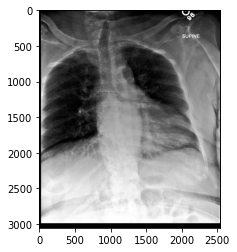

In [6]:
img_path = "/u/home/tanida/datasets/mimic-cxr-jpg/files/p10/p10109668/s56315818/42ce52d0-2f672267-24184026-88dce5a9-decf6213.jpg"
img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
plt.imshow(img, cmap='gray')

In [10]:
x1, y1, x2, y2 = datasets_as_dfs["train"].iloc[59379, 2:6]
print(x1, y1, x2, y2)

0 1910 0 2182
